In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

In [2]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
consDF = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')
cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')

In [3]:
acctDF.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90


In [4]:
consDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0


In [5]:
cat_map

,category_id,category
0,0,SELF_TRANSFER
1,1,EXTERNAL_TRANSFER
2,2,DEPOSIT
3,3,PAYCHECK
4,4,MISCELLANEOUS
5,5,PAYCHECK_PLACEHOLDER
6,6,REFUND
7,7,INVESTMENT_INCOME
8,8,OTHER_BENEFITS
9,9,UNEMPLOYMENT_BENEFITS


In [6]:
trxnDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16


In [7]:
consDF = consDF.dropna()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [9]:
consDF['evaluation_date'] = pd.to_datetime(consDF['evaluation_date'])

# Create a new feature 'days_since_evaluation' representing the number of days since the evaluation date
consDF['days_since_evaluation'] = (pd.Timestamp('now') - consDF['evaluation_date']).dt.total_seconds()

In [11]:
# Drop the original 'evaluation_date' column
X = consDF.drop(columns=['DQ_TARGET', 'evaluation_date'])
y = consDF['DQ_TARGET']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [12]:
# Get feature importances
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

most_important_feature = feature_importance_df.iloc[0]
print(f"The most important feature is: {most_important_feature['Feature']} with an importance score of {most_important_feature['Importance']:.4f}")

The most important feature is: prism_consumer_id with an importance score of 0.3850


In [13]:
most_important_feature['Feature']

'prism_consumer_id'

In [14]:
X_train_single = X_train[[most_important_feature['Feature']]]
X_test_single = X_test[[most_important_feature['Feature']]]

single_feature_model = RandomForestClassifier(random_state=42)
single_feature_model.fit(X_train_single, y_train)

RandomForestClassifier(random_state=42)

In [15]:
X_train_single = X_train[['credit_score']]
X_test_single = X_test[['credit_score']]

single_feature_model = RandomForestClassifier(random_state=42)
single_feature_model.fit(X_train_single, y_train)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = single_feature_model.predict(X_test_single)
y_pred_proba = single_feature_model.predict_proba(X_test_single)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy using the single best feature: {accuracy:.4f}")
print(f"ROC AUC using the single best feature: {roc_auc:.4f}")
print(f"R² score using the single best feature: {r2:.4f}")

Accuracy using the single best feature: 0.9079
ROC AUC using the single best feature: 0.6798
R² score using the single best feature: -0.1633


In [17]:
consDF

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,days_since_evaluation
0,0,2021-09-01,726.0,0.0,1.086984e+08
1,1,2021-07-01,626.0,0.0,1.140552e+08
2,2,2021-05-01,680.0,0.0,1.193256e+08
3,3,2021-03-01,734.0,0.0,1.245960e+08
4,4,2021-10-01,676.0,0.0,1.061064e+08
...,...,...,...,...,...
13995,13995,2022-01-22,802.0,0.0,9.634323e+07
13996,13996,2022-02-01,652.0,0.0,9.547923e+07
13997,13997,2021-12-24,765.0,0.0,9.884883e+07
13998,13998,2022-01-30,685.0,0.0,9.565203e+07


### Single Feature using Transaction Frequency

In [18]:
transaction_frequency = (
    trxnDF.groupby('prism_consumer_id')
    .size()  # Count transactions per consumer
    .reset_index(name='transaction_frequency')
)

In [19]:
consDF_merge = consDF.merge(transaction_frequency, on='prism_consumer_id', how='left')

In [20]:
consDF_merge['transaction_frequency'] = consDF_merge['transaction_frequency'].fillna(0)


In [21]:
X = consDF_merge.drop(columns=['DQ_TARGET', 'evaluation_date'])
y = consDF_merge['DQ_TARGET']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_single = X_train[['transaction_frequency']]
X_test_single = X_test[['transaction_frequency']]


single_feature_model = RandomForestClassifier(random_state=42)
single_feature_model.fit(X_train_single, y_train)

y_pred = single_feature_model.predict(X_test_single)
y_pred_proba = single_feature_model.predict_proba(X_test_single)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy using transaction frequency: {accuracy:.4f}")
print(f"ROC AUC using transaction frequency: {roc_auc:.4f}")
print(f"R² score using transaction frequency: {r2:.4f}")


Accuracy using transaction frequency: 0.9050
ROC AUC using transaction frequency: 0.4835
R² score using transaction frequency: -0.2002


### Single Feature (Sum of Balance)

In [22]:
# Calculate total balance per consumer
total_balance = (
    acctDF.groupby('prism_consumer_id')['balance']
    .sum()
    .reset_index(name='total_balance')
)

# Merge with consDF
consDF_merge = consDF.merge(total_balance, on='prism_consumer_id', how='left')
consDF_merge['total_balance'] = consDF_merge['total_balance'].fillna(0)


In [23]:
X = consDF_merge.drop(columns=['DQ_TARGET', 'evaluation_date'])
y = consDF_merge['DQ_TARGET']

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_single = X_train[['total_balance']]
X_test_single = X_test[['total_balance']]


single_feature_model = RandomForestClassifier(random_state=42)
single_feature_model.fit(X_train_single, y_train)

y_pred = single_feature_model.predict(X_test_single)
y_pred_proba = single_feature_model.predict_proba(X_test_single)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy using transaction frequency: {accuracy:.4f}")
print(f"ROC AUC using transaction frequency: {roc_auc:.4f}")
print(f"R² score using transaction frequency: {r2:.4f}")

Accuracy using transaction frequency: 0.8708
ROC AUC using transaction frequency: 0.5995
R² score using transaction frequency: -0.6318


In [24]:
### Single Feature (Credit-To-Debit Ratio)

In [25]:
# Calculate credit and debit counts
credit_debit_ratio = (
    trxnDF.groupby(['prism_consumer_id', 'credit_or_debit'])['amount']
    .count()
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={'CREDIT': 'credit_count', 'DEBIT': 'debit_count'})
)


credit_debit_ratio['credit_debit_ratio'] = (
    credit_debit_ratio['credit_count'] / (credit_debit_ratio['debit_count'] + 1)  # Avoid division by zero
)


consDF_merge = consDF.merge(credit_debit_ratio[['prism_consumer_id', 'credit_debit_ratio']], on='prism_consumer_id', how='left')
consDF_merge['credit_to_debit_ratio'] = consDF_merge['credit_debit_ratio'].fillna(0)


In [26]:
consDF_merge

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,days_since_evaluation,credit_debit_ratio,credit_to_debit_ratio
0,0,2021-09-01,726.0,0.0,1.086984e+08,0.102426,0.102426
1,1,2021-07-01,626.0,0.0,1.140552e+08,0.290984,0.290984
2,2,2021-05-01,680.0,0.0,1.193256e+08,0.220109,0.220109
3,3,2021-03-01,734.0,0.0,1.245960e+08,0.230769,0.230769
4,4,2021-10-01,676.0,0.0,1.061064e+08,0.149813,0.149813
...,...,...,...,...,...,...,...
11995,13995,2022-01-22,802.0,0.0,9.634323e+07,2.315789,2.315789
11996,13996,2022-02-01,652.0,0.0,9.547923e+07,0.322581,0.322581
11997,13997,2021-12-24,765.0,0.0,9.884883e+07,3.300000,3.300000
11998,13998,2022-01-30,685.0,0.0,9.565203e+07,0.404651,0.404651


In [27]:
X = consDF_merge.drop(columns=['DQ_TARGET', 'evaluation_date'])
y = consDF_merge['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_single = X_train[['credit_debit_ratio']]
X_test_single = X_test[['credit_debit_ratio']]


single_feature_model = RandomForestClassifier(random_state=42)
single_feature_model.fit(X_train_single, y_train)

y_pred = single_feature_model.predict(X_test_single)
y_pred_proba = single_feature_model.predict_proba(X_test_single)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred)

print(f"Accuracy using transaction frequency: {accuracy:.4f}")
print(f"ROC AUC using transaction frequency: {roc_auc:.4f}")
print(f"R² score using transaction frequency: {r2:.4f}")

Accuracy using transaction frequency: 0.8750
ROC AUC using transaction frequency: 0.5505
R² score using transaction frequency: -0.5792


### WEEK 3 Feature Creation

In [28]:
# Merge transaction data with category names
trxnDF = trxnDF.merge(cat_map, left_on='category', right_on='category_id', how='left')
trxnDF['category'] = trxnDF['category_y']
trxnDF = trxnDF.drop(columns=['category_id', 'category_y'])
trxnDF.head()


,prism_consumer_id,prism_transaction_id,category_x,amount,credit_or_debit,posted_date,category
0,3023,0,4,0.05,CREDIT,2021-04-16,MISCELLANEOUS
1,3023,1,12,481.56,CREDIT,2021-04-30,LOAN
2,3023,2,4,0.05,CREDIT,2021-05-16,MISCELLANEOUS
3,3023,3,4,0.07,CREDIT,2021-06-16,MISCELLANEOUS
4,3023,4,4,0.06,CREDIT,2021-07-16,MISCELLANEOUS


In [29]:
# Convert dates to datetime format
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])
consDF['evaluation_date'] = pd.to_datetime(consDF['evaluation_date'])
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

In [30]:
# Aggregate transactions by category type per consumer
category_spending = trxnDF.pivot_table(index='prism_consumer_id',
                                       columns='category',
                                       values='amount',
                                       aggfunc='sum',
                                       fill_value=0)
category_spending

category,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,AUTO_LOAN,BANKING_CATCH_ALL,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CORPORATE_PAYMENTS,CREDIT_CARD_PAYMENT,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,0.00,540.00,527.15,0.00,1980.00,0.00,0.00,0.0,0.0,0.00,...,19.96,0.0,0.0,0.0,2683.77,2603.52,0.0,2.48,108.75,0.0
1,0.00,6999.13,195.18,0.00,0.00,0.00,251.43,0.0,0.0,0.00,...,2.42,0.0,0.0,0.0,18206.00,2325.40,0.0,51.80,0.00,0.0
10,0.00,4112.00,483.06,0.00,0.00,0.00,0.00,0.0,0.0,180.00,...,92.33,103.0,0.0,0.0,3801.10,0.00,0.0,35.04,0.00,0.0
100,0.00,200.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,16188.17,...,11.75,0.0,0.0,0.0,19702.68,0.00,0.0,0.00,0.00,0.0
1000,0.00,0.00,204.03,0.00,0.00,0.00,0.00,0.0,0.0,14756.05,...,1.37,0.0,0.0,0.0,67142.55,0.00,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.00,1260.18,115.56,672.78,0.00,53.98,167.60,0.0,0.0,512.48,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.0
9996,0.00,0.00,75.39,0.00,184.34,0.00,0.00,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,27.69,0.0
9997,10.50,1053.25,217.60,962.16,0.00,230.00,729.08,0.0,0.0,829.00,...,335.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,136.34,0.0


In [31]:
# Classify income and spending based on 'credit_or_debit' column
trxnDF['income'] = trxnDF['amount'].where(trxnDF['credit_or_debit'] == 'CREDIT', 0)
trxnDF['spending'] = trxnDF['amount'].where(trxnDF['credit_or_debit'] == 'DEBIT', 0)


In [32]:
income_spending = trxnDF.groupby('prism_consumer_id').agg({
    'income': 'sum',
    'spending': 'sum'
}).fillna(0)

In [33]:

income_spending['net_income'] = income_spending['income'] - income_spending['spending']

In [34]:
# Calculate balance changes over time
acctDF.sort_values(by=['prism_consumer_id', 'balance_date'], inplace=True)
acctDF['balance_diff'] = acctDF.groupby('prism_consumer_id')['balance'].diff().fillna(0)
acctDF['days_zero_balance'] = (acctDF['balance'] == 0).astype(int)

In [35]:
# Aggregate balance statistics
balance_features = acctDF.groupby('prism_consumer_id').agg({
    'balance': ['mean', 'std', 'min', 'max'],
    'balance_diff': ['mean', 'std', 'min', 'max'],
    'days_zero_balance': 'sum'
})

In [36]:
# Flatten multi-level column names
balance_features.columns = ['_'.join(col).strip() for col in balance_features.columns]


In [37]:
# Merge all features
final_features = consDF.merge(income_spending, on='prism_consumer_id', how='left')
final_features = final_features.merge(balance_features, on='prism_consumer_id', how='left')
final_features = final_features.merge(category_spending, on='prism_consumer_id', how='left')


In [38]:
final_features.fillna(0, inplace=True)

In [39]:
final_features.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,days_since_evaluation,income,spending,net_income,balance_mean,balance_std,...,REFUND,RENT,RISK_CATCH_ALL,RTO_LTO,SELF_TRANSFER,TAX,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS
0,0,2021-09-01,726.0,0.0,1.086984e+08,14386.82,14908.41,-521.59,160.185,190.190511,...,19.96,0.0,0.0,0.0,2683.77,2603.52,0.0,2.48,108.75,0.0
1,1,2021-07-01,626.0,0.0,1.140552e+08,24903.80,23098.37,1805.43,1651.210,2206.130731,...,2.42,0.0,0.0,0.0,18206.00,2325.40,0.0,51.80,0.00,0.0
2,2,2021-05-01,680.0,0.0,1.193256e+08,22764.71,22334.58,430.13,1402.680,1638.719965,...,56.48,0.0,0.0,0.0,19865.91,6094.48,0.0,24.50,391.50,0.0
3,3,2021-03-01,734.0,0.0,1.245960e+08,22641.25,19846.01,2795.24,3833.505,4039.962670,...,37.88,0.0,0.0,0.0,19564.38,2044.04,0.0,1286.71,0.00,5700.0
4,4,2021-10-01,676.0,0.0,1.061064e+08,14966.11,17509.71,-2543.60,197.275,274.845335,...,116.50,0.0,0.0,0.0,5562.27,0.00,0.0,150.00,673.23,12020.0


In [40]:
# Create rolling spending trends
for days in [30, 90, 180]:
    recent_trxns = trxnDF[trxnDF['posted_date'] >= (trxnDF['posted_date'].max() - pd.Timedelta(days=days))]
    trend_features = recent_trxns.groupby('prism_consumer_id').agg({
        'spending': ['sum', 'mean', 'std'],
        'income': ['sum', 'mean', 'std']
    }).fillna(0)
    trend_features.columns = [f"{col[0]}_{days}d_{col[1]}" for col in trend_features.columns]
    consDF = consDF.merge(trend_features, on='prism_consumer_id', how='left')


In [41]:
# Spending Ratios
trxnDF['essential_spending'] = trxnDF['amount'].where(trxnDF['category'].isin(['GROCERIES', 'BILLS_UTILITIES', 'RENT']), 0)
trxnDF['non_essential_spending'] = trxnDF['amount'].where(~trxnDF['category'].isin(['GROCERIES', 'BILLS_UTILITIES', 'RENT']), 0)

spending_ratios = trxnDF.groupby('prism_consumer_id').agg({
    'essential_spending': 'sum',
    'non_essential_spending': 'sum'
}).fillna(0)

spending_ratios['essential_ratio'] = spending_ratios['essential_spending'] / (spending_ratios['essential_spending'] + spending_ratios['non_essential_spending'] + 1e-6)
spending_ratios['non_essential_ratio'] = spending_ratios['non_essential_spending'] / (spending_ratios['essential_spending'] + spending_ratios['non_essential_spending'] + 1e-6)

In [42]:
# High-Value & Small-Dollar Transactions
percentiles = trxnDF.groupby('prism_consumer_id')['amount'].quantile([0.10, 0.90]).unstack()
percentiles.columns = ['small_txn_threshold', 'large_txn_threshold']
trxnDF = trxnDF.merge(percentiles, on='prism_consumer_id', how='left')

trxnDF['high_value_txn'] = (trxnDF['amount'] >= trxnDF['large_txn_threshold']).astype(int)
trxnDF['small_value_txn'] = (trxnDF['amount'] <= trxnDF['small_txn_threshold']).astype(int)

txn_stats = trxnDF.groupby('prism_consumer_id').agg({
    'high_value_txn': 'sum',
    'small_value_txn': 'sum'
}).fillna(0)

In [43]:
# Merge all new features into final dataset
final_features = final_features.merge(spending_ratios, on='prism_consumer_id', how='left')
final_features = final_features.merge(txn_stats, on='prism_consumer_id', how='left')

In [44]:
final_features.fillna(0, inplace=True)

In [45]:
final_features.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,days_since_evaluation,income,spending,net_income,balance_mean,balance_std,...,TIME_OR_STUFF,TRANSPORATION,TRAVEL,UNEMPLOYMENT_BENEFITS,essential_spending,non_essential_spending,essential_ratio,non_essential_ratio,high_value_txn,small_value_txn
0,0,2021-09-01,726.0,0.0,1.086984e+08,14386.82,14908.41,-521.59,160.185,190.190511,...,0.0,2.48,108.75,0.0,997.63,28297.60,0.034054,0.965946,41.0,41.0
1,1,2021-07-01,626.0,0.0,1.140552e+08,24903.80,23098.37,1805.43,1651.210,2206.130731,...,0.0,51.80,0.00,0.0,427.27,47574.90,0.008901,0.991099,39.0,32.0
2,2,2021-05-01,680.0,0.0,1.193256e+08,22764.71,22334.58,430.13,1402.680,1638.719965,...,0.0,24.50,391.50,0.0,371.36,44727.93,0.008234,0.991766,51.0,45.0
3,3,2021-03-01,734.0,0.0,1.245960e+08,22641.25,19846.01,2795.24,3833.505,4039.962670,...,0.0,1286.71,0.00,5700.0,166.84,42320.42,0.003927,0.996073,42.0,28.0
4,4,2021-10-01,676.0,0.0,1.061064e+08,14966.11,17509.71,-2543.60,197.275,274.845335,...,0.0,150.00,673.23,12020.0,2362.87,30112.95,0.072758,0.927242,32.0,31.0


In [46]:
final_features.columns

Index(['prism_consumer_id', 'evaluation_date', 'credit_score', 'DQ_TARGET',
       'days_since_evaluation', 'income', 'spending', 'net_income',
       'balance_mean', 'balance_std', 'balance_min', 'balance_max',
       'balance_diff_mean', 'balance_diff_std', 'balance_diff_min',
       'balance_diff_max', 'days_zero_balance_sum', 'ACCOUNT_FEES', 'ATM_CASH',
       'AUTOMOTIVE', 'AUTO_LOAN', 'BANKING_CATCH_ALL', 'BILLS_UTILITIES',
       'BNPL', 'CHILD_DEPENDENTS', 'CORPORATE_PAYMENTS', 'CREDIT_CARD_PAYMENT',
       'DEBT', 'DEPOSIT', 'EDUCATION', 'ENTERTAINMENT', 'ESSENTIAL_SERVICES',
       'EXTERNAL_TRANSFER', 'FITNESS', 'FOOD_AND_BEVERAGES', 'GAMBLING',
       'GENERAL_MERCHANDISE', 'GIFTS_DONATIONS', 'GOVERNMENT_SERVICES',
       'GROCERIES', 'HEALTHCARE_MEDICAL', 'HOME_IMPROVEMENT', 'INSURANCE',
       'INVESTMENT', 'INVESTMENT_INCOME', 'LEGAL', 'LOAN', 'MISCELLANEOUS',
       'MORTGAGE', 'OTHER_BENEFITS', 'OVERDRAFT', 'PAYCHECK', 'PENSION',
       'PETS', 'REFUND', 'RENT', 'RISK_

In [58]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

### Categories Feature Creation

In [50]:
def generate_category_features(trxnDF, cat_map, categories):
    """
    Generates transaction-based features for each selected category over multiple time windows.
    
    Parameters:
        trxnDF (pd.DataFrame): DataFrame containing transaction data.
        cat_map (pd.DataFrame): DataFrame mapping category IDs to category names.
        categories (str or list): One or more transaction categories to filter.

    Returns:
        pd.DataFrame: Aggregated features per prism_consumer_id.
    """
    if isinstance(categories, str):
        categories = [categories]

    # trxnDF = trxnDF.merge(cat_map, left_on='category', right_on='category_id', how='left')
    # trxnDF['category'] = trxnDF['category_y']
    # trxnDF = trxnDF.drop(columns=['category_id', 'category_y'])

    trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

    time_windows = {
        'overall': None,
        'last_14_days': 14,
        'last_30_days': 30,
        'last_3_months': 90,
        'last_6_months': 180,
        'last_year': 365
    }

    features_dict = {}

    for category in categories:
        # filter transactions for the current category
        filtered_trxn = trxnDF[trxnDF['category'] == category].copy()

        # get last posted date per consumer
        last_posted_dates = filtered_trxn.groupby('prism_consumer_id')['posted_date'].max()

        for window_name, days in time_windows.items():
            if days is None:
                df_time_filtered = filtered_trxn
            else:
                # consumer-specific time filters
                df_time_filtered = filtered_trxn.merge(last_posted_dates, on='prism_consumer_id', suffixes=('', '_latest'))
                df_time_filtered = df_time_filtered[df_time_filtered['posted_date'] >= (df_time_filtered['posted_date_latest'] - pd.Timedelta(days=days))]
                df_time_filtered = df_time_filtered.drop(columns=['posted_date_latest'])

            # aggregate features
            agg_features = df_time_filtered.groupby('prism_consumer_id')['amount'].agg(
                mean='mean',
                median='median',
                std='std',
                max='max',
                min='min',
                count='count'
            )

            # total transaction count per consumer in the time window
            total_trxn_counts = trxnDF.groupby('prism_consumer_id')['amount'].count()

            # compute percentage of transactions in this category for the time window
            percentage_trxn = (agg_features['count'] / total_trxn_counts).fillna(0)
            percentage_trxn = percentage_trxn.rename(f"{category}_{window_name}_percent")

            agg_features = agg_features.rename(columns=lambda x: f"{category}_{window_name}_{x}")

            features_dict[f"{category}_{window_name}"] = pd.concat([agg_features, percentage_trxn], axis=1)


    final_features = pd.concat(features_dict.values(), axis=1).fillna(0)
    return final_features


In [51]:
category_features = generate_category_features(trxnDF, cat_map, ['GAMBLING', 'DEBT'])
category_features


,GAMBLING_overall_mean,GAMBLING_overall_median,GAMBLING_overall_std,GAMBLING_overall_max,GAMBLING_overall_min,GAMBLING_overall_count,GAMBLING_overall_percent,GAMBLING_last_14_days_mean,GAMBLING_last_14_days_median,GAMBLING_last_14_days_std,...,DEBT_last_6_months_min,DEBT_last_6_months_count,DEBT_last_6_months_percent,DEBT_last_year_mean,DEBT_last_year_median,DEBT_last_year_std,DEBT_last_year_max,DEBT_last_year_min,DEBT_last_year_count,DEBT_last_year_percent
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
10,41.500000,31.500,50.626080,103.00,0.00,4.0,0.011730,31.500,31.500,44.547727,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
10001,312.100000,312.100,0.000000,312.10,312.10,1.0,0.001344,312.100,312.100,0.000000,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
10015,106.245000,106.245,146.717586,209.99,2.50,2.0,0.001751,106.245,106.245,146.717586,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
10019,28.995000,28.995,5.649783,32.99,25.00,2.0,0.001371,32.990,32.990,0.000000,...,119.99,6.0,0.004112,119.99,119.99,0.0,119.99,119.99,7.0,0.004798
10024,46.011349,17.310,77.631683,503.00,1.04,126.0,0.103789,30.859,17.310,47.280264,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000,0.000,0.000000,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
9996,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000,0.000,0.000000,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000
9997,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000,0.000,0.000000,...,0.00,0.0,0.000000,0.00,0.00,0.0,0.00,0.00,0.0,0.000000


In [52]:
remove_categories = ['CHILD_DEPENDENTS', 'HEALTHCARE_MEDICAL', 'UNEMPLOYMENT_BENEFITS', 'EDUCATION']
categories = list(filter(lambda x: x not in remove_categories, list(cat_map['category'])))

In [53]:
category_features = generate_category_features(trxnDF, cat_map, categories)
category_features

,SELF_TRANSFER_overall_mean,SELF_TRANSFER_overall_median,SELF_TRANSFER_overall_std,SELF_TRANSFER_overall_max,SELF_TRANSFER_overall_min,SELF_TRANSFER_overall_count,SELF_TRANSFER_overall_percent,SELF_TRANSFER_last_14_days_mean,SELF_TRANSFER_last_14_days_median,SELF_TRANSFER_last_14_days_std,...,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_6_months_percent,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count,PENSION_last_year_percent
prism_consumer_id,,,,,,,,,,,,,,,,,,,,,
0,116.685652,36.150,255.442921,1080.21,6.00,23.0,0.056373,113.333333,20.00,161.658075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,233.410256,200.000,229.152784,1000.00,20.00,78.0,0.248408,283.333333,150.00,297.972950,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,237.568750,185.275,191.174969,550.00,20.00,16.0,0.046921,500.000000,500.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,547.296667,500.000,341.698602,1400.00,150.00,36.0,0.295082,472.032000,416.16,329.793155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,828.920370,300.000,1974.978578,10000.00,5.22,81.0,0.383886,263.746667,140.53,383.899166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.000000,0.000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
category_features.iloc[:, :6]

,SELF_TRANSFER_overall_mean,SELF_TRANSFER_overall_median,SELF_TRANSFER_overall_std,SELF_TRANSFER_overall_max,SELF_TRANSFER_overall_min,SELF_TRANSFER_overall_count
prism_consumer_id,,,,,,
0,116.685652,36.150,255.442921,1080.21,6.00,23.0
1,233.410256,200.000,229.152784,1000.00,20.00,78.0
10,237.568750,185.275,191.174969,550.00,20.00,16.0
100,547.296667,500.000,341.698602,1400.00,150.00,36.0
1000,828.920370,300.000,1974.978578,10000.00,5.22,81.0
...,...,...,...,...,...,...
9994,0.000000,0.000,0.000000,0.00,0.00,0.0
9995,0.000000,0.000,0.000000,0.00,0.00,0.0
9996,0.000000,0.000,0.000000,0.00,0.00,0.0


In [87]:
final_features_df = pd.read_csv('final_features.csv')

In [88]:
final_features_df.head()

,DQ_TARGET,sum_of_balance,credit_minus_debit,balance_delta,num_income_source,income_std,outflows_amt_mean,outflows_amt_std,outflows_amt_median,outflows_amt_min,...,PENSION_last_6_months_min,PENSION_last_6_months_count,PENSION_last_6_months_percent,PENSION_last_year_mean,PENSION_last_year_median,PENSION_last_year_std,PENSION_last_year_max,PENSION_last_year_min,PENSION_last_year_count,PENSION_last_year_percent
0,0.0,320.37,-521.59,-0.379272,7.0,494.177258,68.249895,185.683316,20.000,0.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3302.42,1805.43,3.245659,6.0,383.271173,113.418109,275.553072,19.660,0.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,2805.36,430.13,0.203075,8.0,609.314103,53.653616,270.477051,13.950,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,7667.01,2795.24,0.481150,9.0,844.130789,102.284215,352.534896,27.100,0.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,394.55,-2543.60,-1.421784,5.0,368.114382,83.476964,174.489962,26.065,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
print(final_features_df.columns)

Index(['DQ_TARGET', 'sum_of_balance', 'credit_minus_debit', 'balance_delta',
       'num_income_source', 'income_std', 'outflows_amt_mean',
       'outflows_amt_std', 'outflows_amt_median', 'outflows_amt_min',
       ...
       'PENSION_last_6_months_min', 'PENSION_last_6_months_count',
       'PENSION_last_6_months_percent', 'PENSION_last_year_mean',
       'PENSION_last_year_median', 'PENSION_last_year_std',
       'PENSION_last_year_max', 'PENSION_last_year_min',
       'PENSION_last_year_count', 'PENSION_last_year_percent'],
      dtype='object', length=2001)


In [165]:
# columns_to_show = ['prism_consumer_id', 'balance_mean', 'SELF_TRANSFER_overall_percent', '6m_count', '6m_over_50']

# final_features_df_subset = final_features_df[columns_to_show]

# final_features_df_subset.head()
# # final_features_df_subset.head().to_csv('subFinalFeatures', index = False)

In [166]:
X_train, X_test, y_train, y_test = train_test_split(
    final_features_df.drop(columns='DQ_TARGET'), final_features_df['DQ_TARGET'], test_size=0.2, random_state=42
)

In [167]:
def fit_model(X_train, y_train, model_type):
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) 
    return model

In [168]:
def predict(X, y, model, proba=True, le=None):
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds

In [169]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [170]:
model = fit_model(X_train, y_train, 'log_reg')

In [171]:
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

In [172]:
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.4966
Accuracy: 0.5696

Confusion Matrix:
[[5043 3759]
 [ 373  425]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.57      0.71      8802
         1.0       0.10      0.53      0.17       798

    accuracy                           0.57      9600
   macro avg       0.52      0.55      0.44      9600
weighted avg       0.86      0.57      0.66      9600



### Feature Selection

In [173]:
from sklearn.linear_model import LassoCV
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import time
import seaborn as sns

In [174]:
# Separate target variable and features
y = final_features_df["DQ_TARGET"]
X = final_features_df.drop(columns=["DQ_TARGET"])

# Ensure no missing values
X.fillna(0, inplace=True)

In [175]:
# LASSO Feature Selection
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

lasso_feature_importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
top_50_lasso = lasso_feature_importance.nlargest(50).index.tolist()

# Point-Biserial Correlation Feature Selection 
point_biserial_scores = {col: abs(pointbiserialr(X[col], y)[0]) for col in X.columns}
top_50_pointbiserial = sorted(point_biserial_scores, key=point_biserial_scores.get, reverse=True)[:50]

top_50 = pd.DataFrame({"LASSO": top_50_lasso, "Point-Biserial": top_50_pointbiserial})

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [176]:
top_50.head()

,LASSO,Point-Biserial
0,sum_of_balance,EXTERNAL_TRANSFER_last_3_months_percent
1,credit_minus_debit,EXTERNAL_TRANSFER_last_30_days_percent
2,balance_delta,EXTERNAL_TRANSFER_last_6_months_percent
3,num_income_source,OVERDRAFT_last_30_days_percent
4,income_std,EXTERNAL_TRANSFER_last_14_days_count


In [177]:
X_top_50 = X[top_50['LASSO']]

X_train, X_test, y_train, y_test = train_test_split(X_top_50, y, test_size=0.2, random_state=42)

model = fit_model(X_train, y_train, 'log_reg')

y_pred, y_pred_proba = predict(X_test, y_test, model)


evaluate_model(y_test, y_pred, y_pred_proba[:,1])

ROC AUC Score: 0.5126
Accuracy: 0.5854

Confusion Matrix:
[[1281  911]
 [  84  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      2192
         1.0       0.12      0.60      0.20       208

    accuracy                           0.59      2400
   macro avg       0.53      0.59      0.46      2400
weighted avg       0.87      0.59      0.68      2400



In [185]:
### Models Training & Evaluation

In [186]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    # Predict model and track inference time
    start_pred = time.time()
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    end_pred = time.time()

    print(f"Prediction Time: {end_pred - start_pred:.4f} seconds")


    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y_test, y_prob),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    return model, metrics

Training Time: 0.5950 seconds
Prediction Time: 0.0137 seconds
HistGB metrics:
	ROC_AUC: 0.737979672585626
	Accuracy: 0.9104166666666667
	Precision: 0.18181818181818182
	Recall: 0.009615384615384616
	F1-Score: 0.0182648401826484
	Confusion Matrix: [[2183    9]
 [ 206    2]]


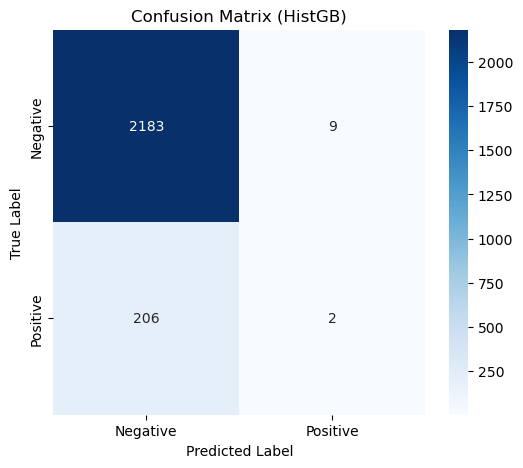

In [187]:
model, results = train_and_evaluate(X_train, y_train, X_test, y_test, model_type="HistGB")

Training Time: 0.5772 seconds
Prediction Time: 0.0135 seconds
HistGB metrics:
	ROC_AUC: 0.737979672585626
	Accuracy: 0.9104166666666667
	Precision: 0.18181818181818182
	Recall: 0.009615384615384616
	F1-Score: 0.0182648401826484
	Confusion Matrix: [[2183    9]
 [ 206    2]]


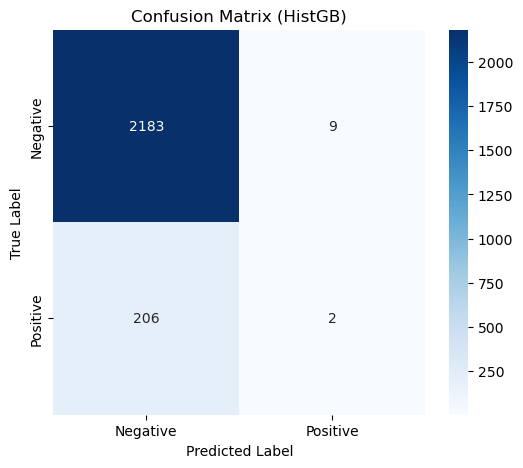

Training Time: 4.8542 seconds
Prediction Time: 0.0070 seconds
CatBoost metrics:
	ROC_AUC: 0.7388526021195957
	Accuracy: 0.9104166666666667
	Precision: 0.1111111111111111
	Recall: 0.004807692307692308
	F1-Score: 0.009216589861751152
	Confusion Matrix: [[2184    8]
 [ 207    1]]


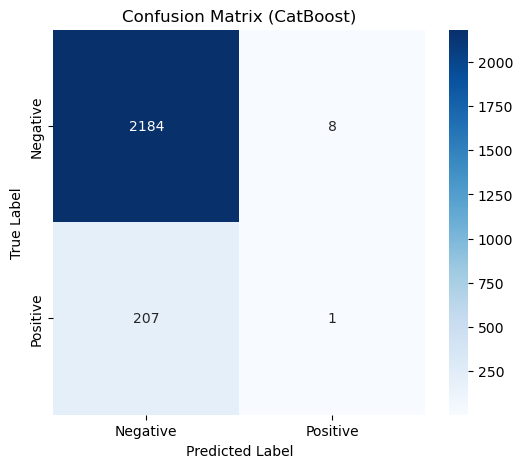

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11729
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 0.2407 seconds
Prediction Time: 0.0102 seconds
LightGBM metrics:
	ROC_AUC: 0.7307725207046604
	Accuracy: 0.9095833333333333
	Precision: 0.09090909090909091
	Recall: 0.004807692307692308
	F1-Score: 0.0091324200913242
	Confusion Matrix: [[2182   10]
 [ 207    1]]


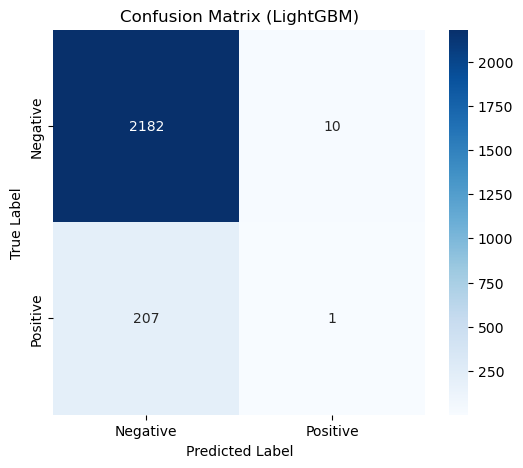

/home/tnp003/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:56:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 0.3465 seconds
Prediction Time: 0.0265 seconds
XGBoost metrics:
	ROC_AUC: 0.7069928674199888
	Accuracy: 0.9104166666666667
	Precision: 0.37037037037037035
	Recall: 0.04807692307692308
	F1-Score: 0.0851063829787234
	Confusion Matrix: [[2175   17]
 [ 198   10]]


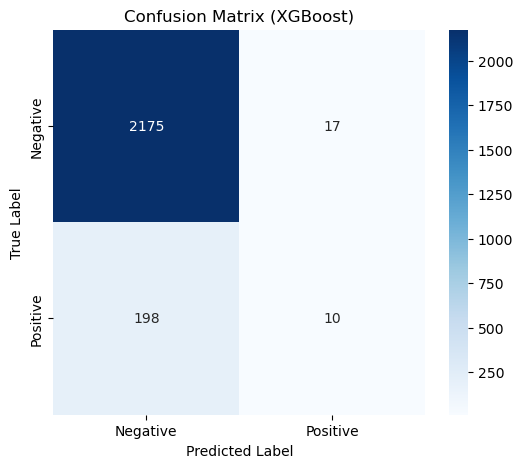

Training Time: 0.6103 seconds
Prediction Time: 0.0033 seconds
LogisticRegression metrics:
	ROC_AUC: 0.5125554902442448
	Accuracy: 0.5854166666666667
	Precision: 0.11980676328502415
	Recall: 0.5961538461538461
	F1-Score: 0.1995172968624296
	Confusion Matrix: [[1281  911]
 [  84  124]]


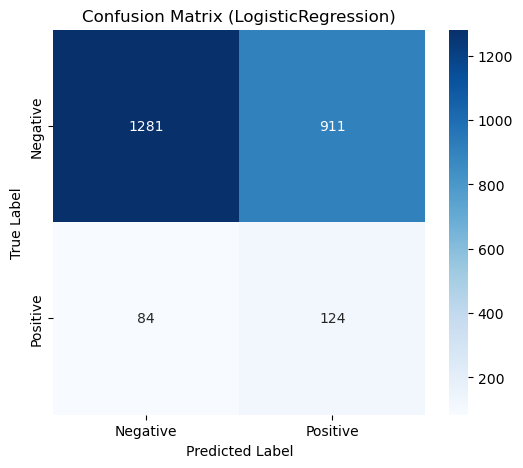

In [188]:
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train, y_train, X_test, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [189]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_standardized = fit_model(X_train_scaled, y_train, 'log_reg')

y_pred_standardized, y_pred_proba_standardized = predict(X_test_scaled, y_test, model_standardized)

print("\nStandardized Model Evaluation:")
evaluate_model(y_test, y_pred_standardized, y_pred_proba_standardized[:, 1])



Standardized Model Evaluation:
ROC AUC Score: 0.6774
Accuracy: 0.9129

Confusion Matrix:
[[2191    1]
 [ 208    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.00      0.00      0.00       208

    accuracy                           0.91      2400
   macro avg       0.46      0.50      0.48      2400
weighted avg       0.83      0.91      0.87      2400



Training Time: 0.5822 seconds
Prediction Time: 0.0111 seconds
HistGB metrics:
	ROC_AUC: 0.7265646932902864
	Accuracy: 0.9129166666666667
	Precision: 0.45454545454545453
	Recall: 0.02403846153846154
	F1-Score: 0.045662100456621
	Confusion Matrix: [[2186    6]
 [ 203    5]]


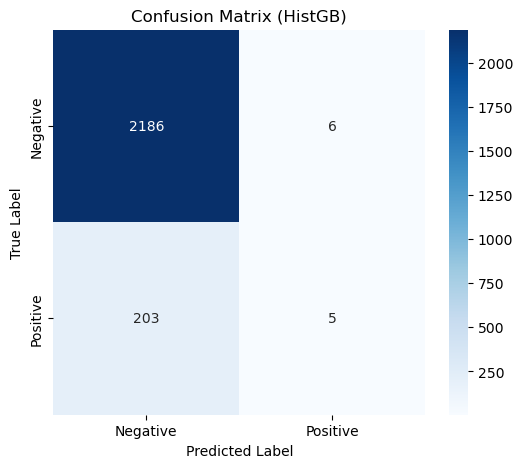

Training Time: 4.8704 seconds
Prediction Time: 0.0059 seconds
CatBoost metrics:
	ROC_AUC: 0.7336764370437956
	Accuracy: 0.9116666666666666
	Precision: 0.16666666666666666
	Recall: 0.004807692307692308
	F1-Score: 0.009345794392523364
	Confusion Matrix: [[2187    5]
 [ 207    1]]


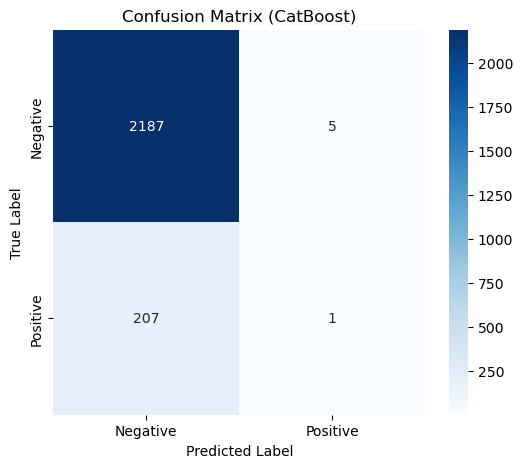

[LightGBM] [Info] Number of positive: 798, number of negative: 8802
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11754
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083125 -> initscore=-2.400626
[LightGBM] [Info] Start training from score -2.400626
Training Time: 0.2605 seconds
Prediction Time: 0.0086 seconds
LightGBM metrics:
	ROC_AUC: 0.728786496350365
	Accuracy: 0.9091666666666667
	Precision: 0.08333333333333333
	Recall: 0.004807692307692308
	F1-Score: 0.00909090909090909
	Confusion Matrix: [[2181   11]
 [ 207    1]]


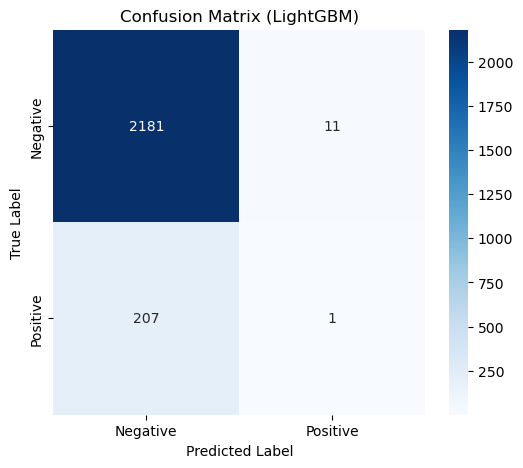

/home/tnp003/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [05:57:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]